In [64]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import networkx as nx

In [6]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output

process = psutil.Process(os.getpid())

In [65]:
torch.get_num_threads()

24

In [57]:
messages = [torch.tensor(np.random.randn(10)) for i in range(2)]

In [58]:
%timeit torch.cat([message[:, None] for message in messages], -1).max(dim=1)[0][None, :]

27.7 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [59]:
%timeit torch.cat([message[:, None] for message in messages], -1).max(dim=1, keepdim=True)[0].t()

27.2 µs ± 668 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [62]:
%timeit torch.stack(messages).max(dim=0)[0][None, :]

23.5 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
%timeit torch.stack(messages).max(dim=0, keepdim=True)[0].t()

21.9 µs ± 482 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Tools

In [4]:
def get_lablesx(graphx):
    lablesx = dict()
    for node_id, node in graphx.nodes(data=True):
        lablesx[node_id] = node['signal']
    return lablesx


def get_central_node(lablesx):
    """
    return id of random node
    """
    lablesx_np = np.array(list(lablesx.values()))
    possible_labels=np.unique(lablesx_np)
    return list(lablesx.keys())[np.random.choice(np.where(lablesx_np == np.random.choice(possible_labels))[0])]


def unique_neighbours_of_k_order(graphx: nx.DiGraph, node: int, order: int):
    neighbours = set([node])
    neighbours_layers_sets = list([neighbours])
    for k in range(order):
        neighbours = set((neighbour 
                          for node in neighbours 
                          for neighbour in (list(graphx.successors(node)) + list(graphx.predecessors(node))) ))
        neighbours_layers_sets.append(neighbours)
    
    neighbours = {}
    cumulative = set()
    k = 0
    for layer in neighbours_layers_sets:
        for node in (layer - cumulative):
            neighbours[node] = k
        cumulative = cumulative.union(layer)
        
        k += 1
    return neighbours


def get_subgraph_from_point(graphx: nx.Graph, central_node: int, 
                                 node_shape: int, edge_shape: int, 
                                 message_passers: dict, state_updater: StateUpdater,
                                 order: int = 2):
    if order > 0:
        k_order_neighbours = unique_neighbours_of_k_order(graphx, central_node, order)    
        subgraphx = graphx.subgraph(list(k_order_neighbours.keys()))
    else:
        subgraphx = graphx
        
    # add torch nodes to subgraph attributes
    for node_id, node in subgraphx.nodes(data=True):
        node_torch = Node(
            name=str(node_id),
            data=np.array(
                [
                    node['features']['TX'],
                    node['features']['TY'],
                    (node['features']['chi2'] - 1.5) / 1.5
                ] + (node_shape - 3) * [0.]
            )
        )
        node_torch.set_state_updater(state_updater=state_updater)
        node['node_torch'] = node_torch
        node['order'] = k_order_neighbours[node_id]
        
        
    # add troch edges to subgraph attributes
    for node_u_idx, node_v_idx, edge_uv in subgraphx.edges(data=True):
        node_u_torch = subgraphx.node[node_u_idx]['node_torch']
        node_v_torch = subgraphx.node[node_v_idx]['node_torch']

        # create edge that connects node_u node_v
        edge_uv_torch = Edge(
            name=node_u_torch.name + node_v_torch.name, 
            data=np.array(
                [
                    edge_uv['features']['dsx'],
                    edge_uv['features']['dsy'],
                    edge_uv['features']['dsz'],
                    edge_uv['features']['dsxProjLeft'],
                    edge_uv['features']['dsyProjLeft'],
                    edge_uv['features']['dsxProjRight'],
                    edge_uv['features']['dsyProjRight'],
                    (edge_uv['features']['r'] - 200) / 200
                    
                ] + (edge_shape - 8) * [0.]
            )
        )
        edge_uv['edge_torch'] = edge_uv_torch
        
        # different message passers for different stages?
        edge_uv['message_passers'] = message_passers

    return subgraphx


def run_message_passing(subgraphx: nx.Graph, step: int):
    # passing messages
    for i, j, edge in subgraphx.edges(data=True):
        edge['message_passers'][step].pass_message(
            subgraphx.node[j]['node_torch'], 
            subgraphx.node[i]['node_torch'], 
            edge['edge_torch'])
              
    # updating nodes
    for i, node in subgraphx.nodes(data=True):
        node['node_torch'].update()
    
    return True


def make_predictions(subgraphx: nx.Graph, readout: 'Readout', order: int):
    """
    readout: Readout
    """
    nodes_predictions_means = []
    nodes_predictions_log_sigmas = []
    true_labels = []
    # make nodes predictions
    for node_id, node in subgraphx.nodes(data=True):
        if node['order'] <= order:
            prediction_means, predictions_log_sigmas = readout.predict(node['node_torch'])
            nodes_predictions_means.append(prediction_means)
            nodes_predictions_log_sigmas.append(predictions_log_sigmas)
            true_labels.append(node['signal'])
    return nodes_predictions_means, nodes_predictions_log_sigmas, true_labels

In [5]:
%%time
graphx_list_train = []
for k in np.arange(0, 10):
    graphx_list_train.append(nx.read_gpickle('./data/clean_brick_{}.pkl'.format(k)))
lablesx_list_train = []
for graphx in graphx_list_train:
    lablesx_list_train.append(get_lablesx(graphx=graphx))

CPU times: user 2.28 s, sys: 348 ms, total: 2.63 s
Wall time: 2.63 s


In [6]:
class MessagePasserNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32) # 32 / 64
        self.dropout_1 = nn.Dropout(p=0.01)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(64, 32)
        self.nonlinear_2 = nn.LeakyReLU()
        self.output = nn.Linear(32, output)

    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        # x = self.nonlinear_2(self.layer_2(x))
        return self.output(x)
    
class StateUpdaterNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.gru = nn.GRUCell(input, output)
    
    def forward(self, x, hidden_state):
        hidden_state = self.gru(x, hidden_state)
        return hidden_state

In [7]:
class Readout(object):
    def __init__(self, input: int, output: int, readout: nn.Module):
        """
        :param scope:
        """
        self.input = input
        self.output = output
        self.readout = readout(input, output)

    def predict(self, node: 'Node'):
        return self.readout(node.state[None, :])
    
    
class ReadoutNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 64)
        self.dropout_1 = nn.Dropout(p=0.01)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(64, 32)
        self.mean = nn.Linear(32, output)
        self.log_sigma = nn.Linear(32, output)
        
    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        x = self.layer_2(x)
        relu_shift = 2.
        return self.mean(x), torch.relu(relu_shift + self.log_sigma(x)) - relu_shift

In [8]:
def exctract_subgraph(graphx, lablesx, node_shape, edge_shape, 
                      readout, message_passers, state_updater, 
                      order=3, balanced=True):
    """
    """
    
    # get central node
    neighbourhood = 0
    while neighbourhood == 0:
        if balanced:
            central_node = get_central_node(lablesx=lablesx)
        else:
            
            central_node = np.random.choice(list(lablesx.keys()))
        neighbourhood = len(list(nx.neighbors(graphx, central_node)))
        
    # generate subgraph
    subgraphx = get_subgraph_from_point(
        graphx=graphx, central_node=central_node, 
        node_shape=node_shape, edge_shape=edge_shape,
        message_passers=message_passers, state_updater=state_updater, order=order
    )
    return subgraphx

In [21]:
def loss_gaussian_clusters_wasserstain(means: list, log_sigmas: list, true_labels: list, clusters: list):
    means = np.array(means)
    EPS = 1e-3
    sigmas = np.array([torch.exp(log_sigma) for log_sigma in log_sigmas])
    losses_similar = []
    losses_distant = []
    for mean_cluster, sigma_cluster, label in clusters:
        # close to friends
        losses_similar.append(
            torch.sum(
                torch.mean(
                    (torch.cat(list(means[true_labels==label]), dim=0) / mean_cluster[None, :] - 1.)**2, 
                    dim=1
                )
            )
        )
        #losses_similar.append(
        #    torch.sum(torch.mean((torch.cat(list(sigmas[true_labels==label]), dim=0) 
        #                           - sigma_cluster[None, :])**2, dim=1))
        #)
        
    for mean_cluster_first, sigma_cluster_first, label_first in clusters:
        for mean_cluster_second, sigma_cluster_second, label_second in clusters:
            if label_first != label_second and label_first != 0. and label_second != 0.:
                losses_distant.append(
                    1. / (
                        EPS +
                        torch.sum((mean_cluster_first / mean_cluster_second - 1.)**2)
                        #+ torch.sum((sigma_cluster_first - sigma_cluster_second)**2)
                    )
                )
    """    
    # distant to enemies
        losses_distant.append(
            torch.sum(
1. / (EPS + 
torch.mean((torch.cat(list(means[(true_labels!=label) & (true_labels!=0.)]), dim=0) - mean_cluster[None, :])**2, dim=1)+
torch.mean((torch.cat(list(sigmas[(true_labels!=label) & (true_labels!=0.)]), dim=0) - sigma_cluster[None, :])**2, dim=1)
)
)
)
    """
    """
    # for noise 
    for mean_cluster, sigma_cluster, label in clusters:
        # distant to enemies
        losses_distant.append(
            torch.sum(-torch.mean((torch.cat(means[(true_labels==0.)], dim=0) 
                                   - mean_cluster.detach()[None, :])**2, dim=1))
        )
        
        losses_distant.append(
            torch.sum(-torch.mean((torch.cat(sigmas[(true_labels==0.)], dim=0) 
                                   - sigma_cluster.detach()[None, :])**2, dim=1))
        )
    """
    return sum(losses_similar), sum(losses_distant) / len(means)

In [22]:
def calc_clusters(means: list, log_sigmas: list, true_labels):
    means = np.array(means)
    log_sigmas = np.array(log_sigmas)
    clusters = []
    for label in np.unique(true_labels):
        if label == 0:
            continue
        means_labeled = torch.cat(list(means[true_labels==label]), dim=0)
        log_sigmas_labeled = torch.cat(list(log_sigmas[true_labels==label]), dim=0)
        sigma_cluster_squared = 1 / torch.sum(1 / torch.exp(log_sigmas_labeled)**2, dim=0)
        mean_cluster = torch.sum(means_labeled / torch.exp(log_sigmas_labeled)**2, dim=0) * sigma_cluster_squared
        clusters.append((mean_cluster, torch.sqrt(sigma_cluster_squared), label))
    return clusters

In [27]:
node_shape = 16 # tx, ty, chi2 + zeros
edge_shape = 16 # \delta_x \delta_y r
message_size = 16

message_passer_first = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN)
message_passer_second = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN)
message_passers = {
    0: message_passer_first,
    1: message_passer_second
}
state_updater = StateUpdater(input=message_size, output=node_shape, state_updater=StateUpdaterNN) 

readout = Readout(input=node_shape, output=2, readout=ReadoutNN)

params_mpnn = dict(
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    order=3
)

params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(state_updater.state_updater.parameters()))
print(len(params_trainable))
print(sum([p.numel() for p in params_trainable]))
optimizer_params = optim.SGD(params_trainable, lr=1e-2, weight_decay=1e-9)

24
14052


Nodes pred means tensor([[nan., nan.]])
Nodes predictions sigmas: tensor([[ 0.1353,  0.1353]])
Clusters: (tensor([nan., nan.]), tensor(1.00000e-02 *
       [ 1.7051,  1.7051]), 1.0)



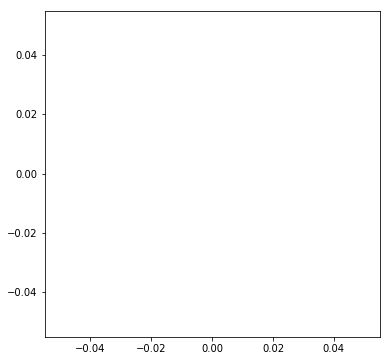

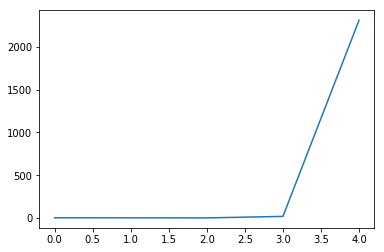

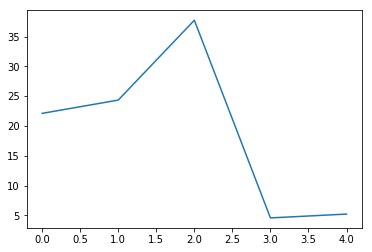

 20%|██        | 4/20 [00:03<00:15,  1.02it/s]


KeyboardInterrupt: 

In [28]:
from IPython.display import clear_output
loss_sim_list = []
loss_dist_list = []
for _ in tqdm(range(100)):
    optimizer_params.zero_grad()

    subgraphx_list=[]
    nodes_predictions_means_all=[]
    nodes_predictions_log_sigmas_all=[]
    true_labels_all=[]
    for i in tqdm(range(20)):
        subgraphx = exctract_subgraph(graphx_list_train[1], lablesx_list_train[1], **params_mpnn)
        run_message_passing(subgraphx=subgraphx, step=0)
        run_message_passing(subgraphx=subgraphx, step=1)
        nodes_predictions_means, nodes_predictions_log_sigmas, true_labels = make_predictions(subgraphx=subgraphx, 
                                                                                              readout=readout, order=1)
        nodes_predictions_means_all.extend(nodes_predictions_means)
        nodes_predictions_log_sigmas_all.extend(nodes_predictions_log_sigmas)
        true_labels_all.extend(true_labels)

    clusters = calc_clusters(means=nodes_predictions_means_all, log_sigmas=nodes_predictions_log_sigmas_all, true_labels=true_labels_all)

    loss_sim, loss_dist = loss_gaussian_clusters_wasserstain(
        means=nodes_predictions_means_all, log_sigmas=nodes_predictions_log_sigmas_all,
        true_labels=true_labels_all, clusters=clusters
    )

    total_loss = -loss_sim + loss_dist


    total_loss.backward()
    loss_sim_list.append(loss_sim.detach().numpy())
    loss_dist_list.append(loss_dist.detach().numpy())
    clear_output()
    print('Nodes pred means', nodes_predictions_means_all[0])
    print('Nodes predictions sigmas:', torch.exp(nodes_predictions_log_sigmas_all[0]))
    print('Clusters:', clusters[0])
    print()
    
    optimizer_params.step()

    nodes_predictions_means_all_numpy = np.array([predictions_means[0].detach().numpy() for predictions_means in nodes_predictions_means_all])
    true_labels_all_numpy = np.array(true_labels_all)
    clusters_means_numpy = np.array([cluster_mean[0].detach().numpy() for cluster_mean in clusters])
    plt.figure(figsize=(6,6))
    for cluster_id in np.unique(true_labels_all_numpy):
        if cluster_id == 0.:
            continue
        plt.scatter(
            nodes_predictions_means_all_numpy[true_labels_all_numpy==cluster_id, 0],
            nodes_predictions_means_all_numpy[true_labels_all_numpy==cluster_id, 1]
        )
    plt.scatter(clusters_means_numpy[:, 0], clusters_means_numpy[:, 1], s=320, marker='^')
    plt.show()
    
    plt.plot(loss_sim_list)
    plt.show()
    
    plt.plot(loss_dist_list)
    plt.show()

In [ ]:
def calc_clusters(means: list, log_sigmas: list, true_labels):
    means = np.array(means)
    log_sigmas = np.array(log_sigmas)
    clusters = []
    for label in np.unique(true_labels):
        if label == 0:
            continue
        means_labeled = torch.cat(list(means[true_labels==label]), dim=0)
        log_sigmas_labeled = torch.cat(list(log_sigmas[true_labels==label]), dim=0)
        sigma_cluster_squared = 1. / torch.sum(1. / torch.exp(log_sigmas_labeled)**2, dim=0)
        mean_cluster = torch.sum(means_labeled / torch.exp(log_sigmas_labeled)**2, dim=0) * sigma_cluster_squared
        clusters.append((mean_cluster, torch.sqrt(sigma_cluster_squared), label))
    return clusters

In [313]:
nodes_predictions_means, nodes_predictions_log_sigmas, true_labels = make_predictions(subgraphx=subgraphx, 
                                                                                              readout=readout, order=2)

In [314]:
calc_clusters(nodes_predictions_means, nodes_predictions_log_sigmas, true_labels)

[(tensor([  3.6446, -49.0464]), tensor([ 1.9221,  1.9221]), 1.0),
 (tensor([  3.6003, -48.2720]), tensor([ 0.1885,  0.1885]), 4.0)]

In [315]:
nodes_predictions_means

[tensor([[  3.6312, -48.8146]]),
 tensor([[  3.6519, -49.1220]]),
 tensor([[  3.6027, -48.6842]]),
 tensor([[  3.4721, -46.7243]]),
 tensor([[  3.7962, -43.4500]]),
 tensor([[  3.6641, -49.3268]]),
 tensor([[  3.6535, -49.1648]]),
 tensor([[  3.6149, -47.6762]]),
 tensor([[  3.6444, -49.0068]]),
 tensor([[  3.6377, -49.0067]]),
 tensor([[  3.6514, -49.1030]]),
 tensor([[  3.6845, -48.7113]]),
 tensor([[  3.6676, -49.3793]]),
 tensor([[  3.6310, -48.8078]]),
 tensor([[  3.6526, -49.0946]]),
 tensor([[  3.6605, -49.2515]]),
 tensor([[  3.6016, -48.8420]]),
 tensor([[  3.6576, -49.1790]]),
 tensor([[  3.6307, -47.8167]]),
 tensor([[  3.6570, -49.2208]]),
 tensor([[  3.6177, -48.5861]]),
 tensor([[  3.6679, -49.3641]]),
 tensor([[  3.6404, -48.9486]]),
 tensor([[  3.6464, -49.0287]]),
 tensor([[  3.6470, -49.0529]]),
 tensor([[  3.6730, -49.4258]]),
 tensor([[  3.6597, -49.3023]]),
 tensor([[  3.6696, -48.1800]]),
 tensor([[  3.2128, -44.9218]]),
 tensor([[  3.6361, -48.9316]]),
 tensor([[

In [262]:
nodes_predictions_means

[tensor([[-11.9898, -67.1712]]),
 tensor([[-11.7889, -67.9430]]),
 tensor([[-13.0870, -73.0011]]),
 tensor([[-12.5974, -70.3705]]),
 tensor([[-12.2185, -69.8108]]),
 tensor([[-12.3342, -69.5012]]),
 tensor([[-11.6138, -65.3576]]),
 tensor([[-12.4292, -69.8284]]),
 tensor([[-12.0556, -67.1276]]),
 tensor([[-10.5999, -58.2425]]),
 tensor([[-12.0269, -67.5683]]),
 tensor([[-12.8697, -71.6226]]),
 tensor([[-10.7374, -59.3056]]),
 tensor([[-13.0081, -72.6047]]),
 tensor([[-12.5396, -70.4323]]),
 tensor([[-11.8136, -66.0661]]),
 tensor([[-11.3157, -62.6272]]),
 tensor([[-12.3323, -70.5647]]),
 tensor([[-13.2421, -73.8679]]),
 tensor([[-13.0372, -72.7835]]),
 tensor([[-11.2550, -62.3960]]),
 tensor([[-12.5431, -69.8698]]),
 tensor([[-11.3309, -62.5844]]),
 tensor([[-11.1381, -62.8627]]),
 tensor([[-12.7756, -71.8311]])]